## Importing the Relevant Libraries
Make sure to remove `CUDA` if you don't have an Nvidia GPU.

In [45]:
using Plots, Flux, LinearAlgebra, CUDA, ProgressMeter
using Flux: @functor
using Statistics: mean
using MLDatasets: MNIST

## Defining the Neural Network
### Creating a Module Instance
Julia does not offer class-based object-orientation like Python does, so if you're coming from PyTorch, then things look quite a bit different – but also not completely different. The fundamental paradigm of Julia's design is multiple-dispatch, so pretty much everything we heavily rely on function-overloading. If those two terms are foreign to you, I recommend prompting your favorite LLM or search engine about them before continuing.

First thing we need to do is to create a struct to hold our layers/submodules. Let's as an example loook at a block of a residual neural network:

In [3]:
struct ResNetBlock
    conv1
    conv2
    skipconv
end

Julia will already offer you a *default* inner constructor for this struct by calling `ResNetBlock(arg1, arg2, arg3)`, but we will create an additional *outer* constructor that makes sure that `arg1`, `arg2` and `arg3` are actually the layers that we want to end up in the struct's attributes. An outer constructor is not really a built-in property of the language, but it is simply an overloaded function of the inner constructor that returns an instance of the struct. Since we did not specify what type the struct's attributes should have, the signature of the inner constructor would look like this, taking any types of input arguments and returning an instance of `ResNetBlock`, i.e. `ResNetBlock(::Any, ::Any, ::Any)::ResNetBlock`.

We will now overload this by defining the following outer constructor, which takes two `Integer` (the super-type for any integer type in Julia) and returns an instance of `ResNetBlock` by calling the inner constructor and passing the layers that we actually want to have in those attributes. Also realize that `return` is not needed in Julia, but could be added for readability.

In [4]:
function ResNetBlock(in_channels::Integer, out_channels::Integer)
    ResNetBlock(
        Conv((3,3), in_channels => out_channels, pad=SamePad()),
        Conv((3,3), out_channels => out_channels, pad=SamePad()),
        Conv((1,1), in_channels => out_channels, pad=SamePad())
    )
end

ResNetBlock

### Making our Module behave like a Function
In PyTorch we would use `__call__` or `forward` functions to make objects callable. In Julia we can define function-like objects or *functors* by creating methods that have the instance of the struct as the method signature. We also type-annotate the passed argument as some kind of array with single-precision floats of dimension 4 – `AbstractArray` is the super-type of all Julia arrays, such as the standard `Array`, but also the `CuArray` for Nvidia GPUs.

In [5]:
function (m::ResNetBlock)(x::AbstractArray{Float32, 4})
    skip = m.skipconv(x)
    x = relu(m.conv1(x))
    x = m.conv2(x) + skip
    return relu(x)
end

As the final step we need to ensure that our `ResNetBlock` behaves like a neural network module. This means that it should be able to recursively load all parameters so that we can either differentiate with respect to them (for training), or that we can copy all of them together between our CPU and our GPU. In PyTorch, this would be taken care of by subclassing `nn.Module`, in Flux, this is taken care of by registering our module as a `@functor`.

In [6]:
@functor ResNetBlock

### Repeating the same for the final network structure

In [7]:
struct ResNetMNIST
    convs
    pool
    fc
end

function ResNetMNIST()
    conv1 = ResNetBlock(1, 64)
    conv2 = ResNetBlock(64, 128)
    conv3 = ResNetBlock(128, 256)
    pool = MaxPool((2,2), pad=SamePad())
    out_feat = 256 * 4 * 4
    fc = Dense(out_feat => 10)
    return ResNetMNIST(
        [conv1, conv2, conv3],
        pool,
        fc
    )
end

function (m::ResNetMNIST)(x::AbstractArray{Float32, 4})
    for conv in m.convs
        x = m.pool(conv(x))
    end
    bs = size(x, ndims(x))
    other = div(length(x), size(x,4))
    return m.fc(reshape(x, (other, bs)))
end

@functor ResNetMNIST

## Loading the Dataset
This will look very familiar to the PyTorch user, except maybe that we use a weird `:train` statement to load our training split. `:train` is of type `Symbol`, bu explaining Julia's symbols is out of the scope of this article. One important thing to note here is that the array dimension order in Flux will be inverted compared to PyTorch: PyTorch uses the B C H W orientation, whereas Flux uses W H C B.

In [34]:
bs = 8
train_ds = MNIST(:train)
test_ds = MNIST(:test)
train_dl = Flux.DataLoader(dataset, batchsize=bs, shuffle=true)
test_dl = Flux.DataLoader(dataset, batchsize=bs, shuffle=false)

7500-element DataLoader(::MNIST, batchsize=8)
  with first element:
  (; features = 28×28×8 Array{Float32, 3}, targets = 8-element Vector{Int64})

## The Training Loop
Julia has an emphasis on the functional programming paradigm and Flux's autodifferntiation engine Zygote also makes use of that. Therefore the syntax of computing gradients is much more similar to JAX than to PyTorch. You need to remind yourself of the mathematical definition of our optimization problem: We want to find the optimal parameters of our model by minimizing a loss between the true class distribution of our data $p(c|x)$ and our predicted class distribution $NN(c|\theta, x)$.
$$
\theta^\star = \argmin_{\theta}\mathcal{L} (f(c|\theta, x), p(c|x))
$$
We do this by gradient descent, so in every optimization step we need to calculate
$$
\frac{\partial \mathcal{L} (f(c|\theta, x), p(c|x))}{\partial \theta}
$$
which is why we need to create a function that takes the model (the parameters $\theta$) as input and returns the loss, so that we can then differentiate that function by the model.
$$
\theta \mapsto \mathcal{L} (f(c|\theta, x), p(c|x))
$$
In Julia we can define such a function in a single line (assuming that `img` and `target` are variables within the scope of the function)
```julia
loss(m) = Flux.logitcrossentropy(m(img), target)
```
For any function, e.g. `func(arg1, arg2)`, Flux allows you to calculate gradients with respect to its passed parameter as
```julia
grad1, grad2 = Flux.gradient(func, arg1, arg2)
```
and since our function only takes the model as its parameters, we can get the gradients as
```julia
model = ResNetMNIST()
grads_theta = Flux.gradient(loss, model)
```
or additionally we can get the loss value returned by using `Flux.withgradient(loss, model)`. With this knowledge we are now able to formulate our training loop.

In [37]:
model = ResNetMNIST() |> gpu 
optim = Flux.setup(Flux.Adam(0.0001), model)

epochs = 30
train_losses = []
test_losses = []
classes = 0:9

@showprogress for epoch in 1:epochs
    train_losses_step = []
    for (i,x) in enumerate(dataloader)
        img = x.features |> gpu
        img = reshape(img, (28, 28, 1, size(img)[end]))
        target = x.targets
        target = Flux.onehotbatch(target, classes) |> gpu

        loss(m) = Flux.logitcrossentropy(m(img), target)

        loss, grads = Flux.withgradient(loss, model)
        
        Flux.update!(optim, model, grads[1])
        push!(train_losses_step, loss |> cpu)
    end
    push!(train_losses, mean(train_losses_step))

    test_losses_step = []
    for (i,x) in enumerate(dataloader)
        img = x.features |> gpu
        img = reshape(img, (28, 28, 1, size(img)[end]))
        target = x.targets
        target = Flux.onehotbatch(target, classes) |> gpu

        loss(m) = Flux.logitcrossentropy(m(img), target)

        loss = loss(model)
        
        push!(test_losses_step, loss |> cpu)
    end
    push!(test_losses, mean(test_losses_step))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:50


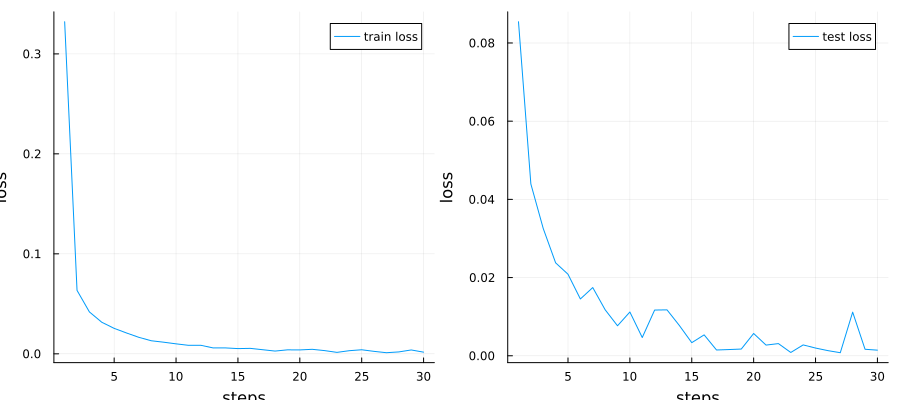

In [44]:
p1 = plot(train_losses, xlabel="steps", ylabel="loss", label="train loss")
p2 = plot(test_losses, xlabel="steps", ylabel="loss", label="test loss")
plot(p1, p2, layout = 2, fmt=:png, size=(900, 400))